In [12]:
import nbimporter
from Random_tree import generate_stochastic_tree, TreeNode, TransitionProbabilities, visualize_tree

In [13]:
import pickle

# Load the saved tree and transition probabilities
with open('tree_1.pkl', 'rb') as f:
    tree_1_root, transition_probs_1 = pickle.load(f)

# Load the saved tree and transition probabilities
with open('tree_2.pkl', 'rb') as f:
    tree_2_root, transition_probs_2 = pickle.load(f)

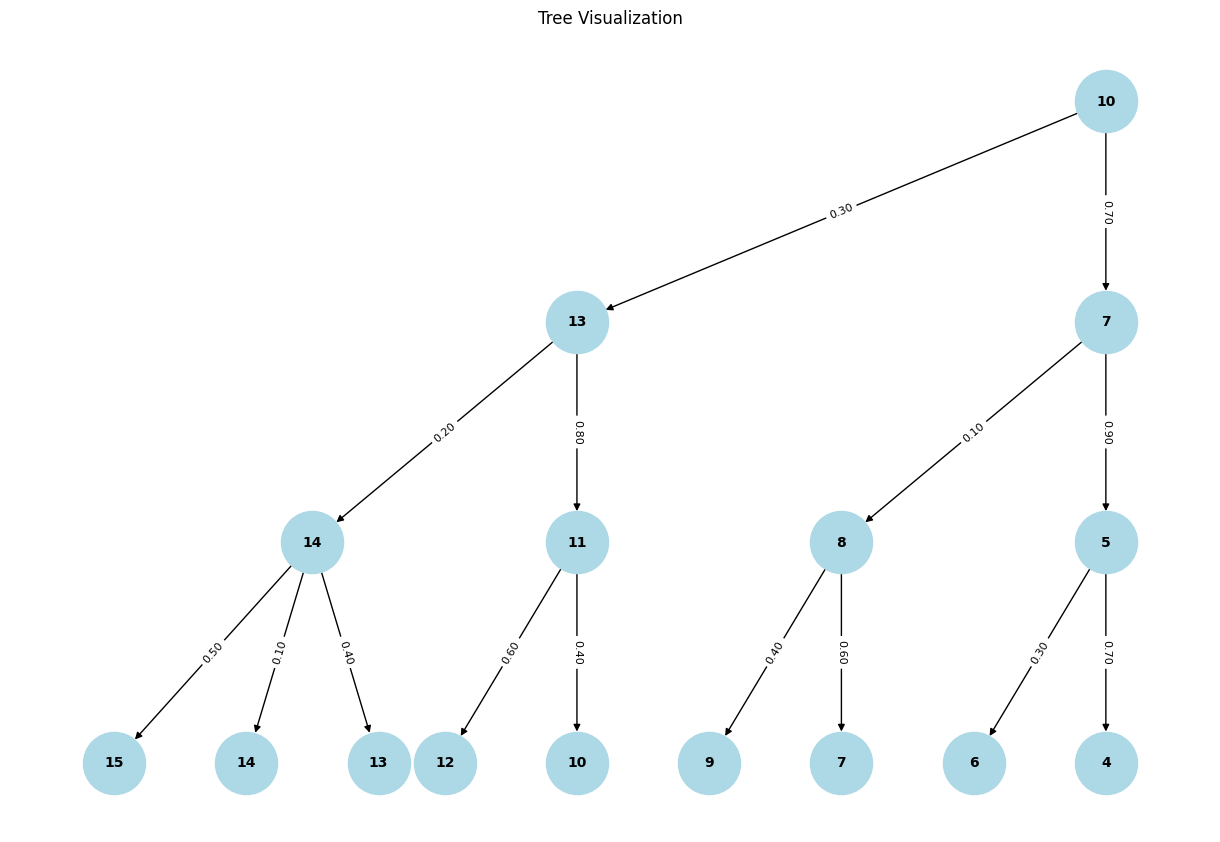

In [14]:
# Example usage
a, b = -20, 45  # Value range for nodes
depth = 3  # Maximum depth
max_children = 7  # Maximum number of children per node

#tree_1_root, transition_probs_1 = generate_stochastic_tree(depth, max_children, a, b)
#tree_2_root, transition_probs_2 = generate_stochastic_tree(depth, max_children, a, b)

visualize_tree(tree_2_root, transition_probs_2)

In [15]:
import numpy as np

def get_nodes_at_depth(tree_root, depth):
    """Collect all nodes at a specific depth from the root."""
    nodes = []

    def traverse(node, path, current_depth):
        # If we've reached the desired depth, store the path to this node
        if current_depth == depth:
            nodes.append(path + [node.value])
            return

        # Recurse to children if we haven't reached the depth yet
        for child, _ in node.children:
            traverse(child, path + [node.value], current_depth + 1)

    traverse(tree_root, [], 0)
    return nodes

def compute_distance_matrix_at_depth(tree1_root, tree2_root, depth):
    """Compute the distance matrix up to a specific depth without precomputed paths."""
    nodes_at_depth_tree1 = get_nodes_at_depth(tree1_root, depth)
    nodes_at_depth_tree2 = get_nodes_at_depth(tree2_root, depth)

    num_nodes_tree1 = len(nodes_at_depth_tree1)
    num_nodes_tree2 = len(nodes_at_depth_tree2)
    distance_matrix = np.zeros((num_nodes_tree1, num_nodes_tree2))

    for i, path1 in enumerate(nodes_at_depth_tree1):
        for j, path2 in enumerate(nodes_at_depth_tree2):
            max_len = max(len(path1), len(path2))
            padded_path1 = path1 + [0] * (max_len - len(path1))
            padded_path2 = path2 + [0] * (max_len - len(path2))
            distance = sum(abs(a - b) for a, b in zip(padded_path1, padded_path2))
            distance_matrix[i, j] = distance

    return distance_matrix

# Example usage
# depth = the depth level you want to compute the distance for
distance_matrix = compute_distance_matrix_at_depth(tree_1_root, tree_2_root, depth)
print("Distance Matrix at depth", depth)
print(distance_matrix)

print(distance_matrix.shape)

Distance Matrix at depth 3
[[ 7.  6.  5.  5.  7. 11. 13. 17. 19.]
 [10.  9.  8.  6.  4.  8. 10. 14. 16.]
 [15. 14. 13.  9.  7.  3.  5.  9. 11.]
 [18. 17. 16. 12. 10.  6.  4.  6.  8.]]
(4, 9)


In [16]:
def compute_marginal_probabilities(tree_root, depth):
    """Compute marginal probabilities at a given depth by aggregating probabilities from the next level."""
    node_probabilities = {}

    def traverse(node, probability, current_depth):
        if current_depth == depth:
            if node not in node_probabilities:
                node_probabilities[node] = 0
            node_probabilities[node] += probability
        else:
            for child, prob in node.children:
                traverse(child, probability * prob, current_depth + 1)

    # Start traversal from root
    traverse(tree_root, 1.0, 0)
    
    # Convert probabilities into a list in the same order as traversal
    return list(node_probabilities.values())

# Compute leaf probabilities for both trees
p = compute_marginal_probabilities(tree_1_root, 3)
p_tilde = compute_marginal_probabilities(tree_2_root, 3)

In [17]:
def get_paths_to_leaves(tree_root, max_depth):
    """Generate all paths from the root to each leaf node up to max_depth."""
    paths = []

    def traverse(node, path, depth):
        if depth == max_depth or not node.children:
            paths.append(path + [node.value])
            return

        for child, _ in node.children:
            traverse(child, path + [node.value], depth + 1)

    traverse(tree_root, [], 0)
    return paths

In [18]:
import numpy as np

def get_node_from_path(tree_root, path):
    """Given a root node and a path (list of values), return the node at the end of the path."""
    current_node = tree_root
    for value in path[1:]:  # Start from the second element, as the first is the root itself
        # Find the child with the given value
        current_node = next(child for child, _ in current_node.children if child.value == value)
    return current_node

from scipy.optimize import linprog

def solver(distance_matrix_subset, pi_ratios, pi_tilde_ratios):
    """
    Solve for the optimal probability matrix that minimizes the cost when
    multiplied with the distance_matrix_subset.
    """
    num_rows, num_cols = distance_matrix_subset.shape

    # Flatten the distance matrix to use it as the cost vector in linprog
    c = distance_matrix_subset.flatten()

    # Constraints
    A_eq = []
    b_eq = []

    # Row constraints: each row should sum to the corresponding value in pi_ratios
    for i in range(num_rows):
        row_constraint = [0] * (num_rows * num_cols)
        for j in range(num_cols):
            row_constraint[i * num_cols + j] = 1
        A_eq.append(row_constraint)
        b_eq.append(pi_ratios[i])

    # Column constraints: each column should sum to the corresponding value in pi_tilde_ratios
    for j in range(num_cols):
        col_constraint = [0] * (num_rows * num_cols)
        for i in range(num_rows):
            col_constraint[i * num_cols + j] = 1
        A_eq.append(col_constraint)
        b_eq.append(pi_tilde_ratios[j])

    # Bounds: each entry in the probability matrix should be non-negative
    bounds = [(0, None)] * (num_rows * num_cols)

    # Solve the linear program
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    
    # Reshape the result back into a matrix of shape (num_rows, num_cols)
    probability_matrix = result.x.reshape(num_rows, num_cols)
    
    return probability_matrix


def compute_distance_matrix_for_subset(node1_path, node2_path, full_distance_matrix):
    """Compute the distance matrix subset for the direct successors of node1 and node2."""
    # Get the actual node objects at the end of each path
    node1 = get_node_from_path(tree_1_root, node1_path)
    node2 = get_node_from_path(tree_2_root, node2_path)
    
    # Successors are paths extended by one additional node for each child
    successors_node1 = [node1_path + [child.value] for child, _ in node1.children]
    successors_node2 = [node2_path + [child.value] for child, _ in node2.children]

    # Get the subset of the full distance matrix corresponding to these successors
    distance_matrix_subset = np.zeros((len(successors_node1), len(successors_node2)))

    for i, path1 in enumerate(successors_node1):
        for j, path2 in enumerate(successors_node2):
            # Compute the L1 distance between the paths to each child
            distance = sum(abs(a - b) for a, b in zip(path1, path2))
            distance_matrix_subset[i, j] = distance

    return distance_matrix_subset

def compute_marginal_probabilities_for_subset(node1_path, node2_path):
    """Compute marginal probabilities for the direct successors of node1 and node2."""
    # Get the actual node objects at the end of each path
    node1 = get_node_from_path(tree_1_root, node1_path)
    node2 = get_node_from_path(tree_2_root, node2_path)

    # Get direct successors and their transition probabilities
    successors_node1 = [(node1_path + [child.value], prob) for child, prob in node1.children]
    successors_node2 = [(node2_path + [child.value], prob) for child, prob in node2.children]

    # Compute marginal probabilities for each set of successors
    pi_ratios = [prob for _, prob in successors_node1]
    pi_tilde_ratios = [prob for _, prob in successors_node2]

    return pi_ratios, pi_tilde_ratios

# Example usage within nested_optimal_transport_loop function

def nested_optimal_transport_loop(tree1_root, tree2_root, max_depth):
    """Set up the nested loop structure for the backward approach and initialize storage for probability matrices."""
    # Dictionary to store matrices for each pair (t, node1, node2)
    probability_matrices = {}

    # Start from the deepest level (T-1) and work backwards to the root (depth 0)
    for depth in range(max_depth - 1, -1, -1):
        # Compute the full distance matrix at depth t+1 for all nodes at that depth
        full_distance_matrix_t_plus_1 = compute_distance_matrix_at_depth(tree1_root, tree2_root, depth + 1)

        # Get nodes at the current depth for both trees
        nodes_tree1 = get_nodes_at_depth(tree1_root, depth)
        nodes_tree2 = get_nodes_at_depth(tree2_root, depth)

        # Iterate over all combinations of nodes in Tree 1 and Tree 2 at this depth
        for node1_path in nodes_tree1:
            for node2_path in nodes_tree2:
                # Define the step name (t, last node in path for node1, last node in path for node2)
                step_name = (depth, node1_path[-1], node2_path[-1])

                # Compute the subset of the distance matrix for the successors of node1 and node2
                distance_matrix_subset = compute_distance_matrix_for_subset(node1_path, node2_path, full_distance_matrix_t_plus_1)

                # Compute the marginal probabilities for the direct successors of node1 and node2
                pi_ratios, pi_tilde_ratios = compute_marginal_probabilities_for_subset(node1_path, node2_path)

                # Call the solver function to get the optimal probability matrix
                probability_matrix = solver(distance_matrix_subset, pi_ratios, pi_tilde_ratios)

                # Store the computed probability matrix in the dictionary
                probability_matrices[step_name] = probability_matrix

                # Print for visualization of structure
                #print(f"Depth {depth}: Step = {step_name}, Probability Matrix Shape = {probability_matrix.shape}")

    return probability_matrices



# Example usage
max_depth = 3  # Adjust based on the actual max depth of your trees
probability_matrices = nested_optimal_transport_loop(tree_1_root, tree_2_root, max_depth)



def compute_final_probability_matrix(probability_matrices, tree1_root, tree2_root, max_depth):
    """Compute the final probability matrix by combining probabilities along paths to each leaf."""
    # Get all paths to leaves for Tree 1 and Tree 2
    paths_tree1 = get_paths_to_leaves(tree1_root, max_depth)
    paths_tree2 = get_paths_to_leaves(tree2_root, max_depth)

    # Initialize the final probability matrix
    final_probability_matrix = np.zeros((len(paths_tree1), len(paths_tree2)))

    # Iterate over all combinations of leaf nodes in Tree 1 and Tree 2
    for i, path1 in enumerate(paths_tree1):
        for j, path2 in enumerate(paths_tree2):
            # Initialize the probability for this leaf pair (i, j)
            probability = 1.0

            # Iterate through each depth level in the paths, stopping one level before the leaf
            for depth in range(max_depth):
                # Extract the current nodes at this depth for path1 and path2
                node1 = path1[depth]
                node2 = path2[depth]

                # Get the probability matrix for this depth and node pair
                step_name = (depth, node1, node2)
                probability_matrix = probability_matrices[step_name]

                # Get the indices of the next nodes in the path (successors at depth + 1)
                next_node1 = path1[depth + 1]
                next_node2 = path2[depth + 1]

                # Find the positions of next_node1 and next_node2 in the successors list
                successors_node1 = [child[-1] for child in get_paths_to_leaves(tree1_root, depth + 1) if child[:-1] == path1[:depth+1]]
                successors_node2 = [child[-1] for child in get_paths_to_leaves(tree2_root, depth + 1) if child[:-1] == path2[:depth+1]]
                
                index1 = successors_node1.index(next_node1)
                index2 = successors_node2.index(next_node2)

                # Multiply by the probability in the matrix for this node transition
                probability *= probability_matrix[index1, index2]

            # Store the final probability for this pair of leaves
            final_probability_matrix[i, j] = probability

    return final_probability_matrix

# Example usage
max_depth = 3  # Adjust based on the actual max depth of your trees
final_probability_matrix = compute_final_probability_matrix(probability_matrices, tree_1_root, tree_2_root, max_depth)
print("Final Probability Matrix:")
print(final_probability_matrix)



Final Probability Matrix:
[[0.0024  0.006   0.024   0.02268 0.      0.      0.      0.      0.12852]
 [0.0276  0.      0.      0.00252 0.0168  0.      0.      0.0714  0.03808]
 [0.      0.      0.      0.      0.04752 0.0168  0.      0.      0.09408]
 [0.      0.      0.      0.1188  0.03168 0.0112  0.042   0.1176  0.18032]]


### For the above methode I can store the distance wihtout needing to compute it again each time.

In [19]:
# Assuming distance_matrix and final_probability_matrix are both of the same shape
def compute_total_cost(distance_matrix, final_probability_matrix):
    """Compute the total cost by element-wise multiplication of the distance matrix and final probability matrix."""
    # Perform element-wise multiplication and then sum all elements
    total_cost = np.sum(distance_matrix * final_probability_matrix)
    return total_cost

# Example usage
total_cost = compute_total_cost(distance_matrix, final_probability_matrix)
print("Total Optimal Transport Cost:", total_cost)

Total Optimal Transport Cost: 10.23896


In [24]:
import numpy as np

def Sinkhorn_iteration(distance_matrix, p_1, p_2, stopping_criterion, lamda):
    """
    Implements the Sinkhorn iteration for nested computation with stopping criteria.

    Parameters:
    - distance_matrix (2D numpy array): n1 x n2 matrix where d_ij represents distances between nodes.
    - p_1 (1D numpy array): n1-length array representing the first probability vector.
    - p_2 (1D numpy array): n2-length array representing the second probability vector.
    - lamda (float): Regularization parameter (lambda > 0).
    - stopping_criterion (float): Threshold for convergence.

    Returns:
    - pi (2D numpy array): Optimal transport plan matrix.
    """
    # Initialize K matrix
    K = np.exp(-lamda * distance_matrix)
    
    # Initialize beta and gamma
    n1, n2 = distance_matrix.shape
    beta = np.ones(n1)
    gamma = np.ones(n2)
    
    max_iter = 1000
    iteration = 0
    epsilon = 1e-10  # Threshold to check for near-zero values
    
    while iteration < max_iter:
        iteration += 1
        
        # Store the previous values to compute changes
        beta_prev = beta.copy()
        gamma_prev = gamma.copy()
        
        # Update beta
        for i in range(n1):
            beta[i] = p_1[i] / np.sum(K[i, :] * gamma)
        
        # Update gamma
        for j in range(n2):
            gamma[j] = p_2[j] / np.sum(K[:, j] * beta)
        
        # Check convergence
        beta_diff = np.sum(np.abs(beta - beta_prev))
        gamma_diff = np.sum(np.abs(gamma - gamma_prev))
        if beta_diff + gamma_diff < stopping_criterion or np.all(beta < epsilon) or np.all(gamma < epsilon):
            break
    
    # Compute the transport plan matrix pi
    pi = np.outer(beta, gamma) * K  # Element-wise multiplication
    
    return pi
    
test = np.round(Sinkhorn_iteration(distance_matrix, p, p_tilde, 0.00001, 3), 3)

print(compute_total_cost(distance_matrix, test))

7.028


In [25]:
def nested_optimal__entropy_transport_loop(tree1_root, tree2_root, max_depth):
    """Set up the nested loop structure for the backward approach and initialize storage for probability matrices."""
    # Dictionary to store matrices for each pair (t, node1, node2)
    probability_matrices = {}

    # Start from the deepest level (T-1) and work backwards to the root (depth 0)
    for depth in range(max_depth - 1, -1, -1):
        # Compute the full distance matrix at depth t+1 for all nodes at that depth
        full_distance_matrix_t_plus_1 = compute_distance_matrix_at_depth(tree1_root, tree2_root, depth + 1)

        # Get nodes at the current depth for both trees
        nodes_tree1 = get_nodes_at_depth(tree1_root, depth)
        nodes_tree2 = get_nodes_at_depth(tree2_root, depth)

        # Iterate over all combinations of nodes in Tree 1 and Tree 2 at this depth
        for node1_path in nodes_tree1:
            for node2_path in nodes_tree2:
                # Define the step name (t, last node in path for node1, last node in path for node2)
                step_name = (depth, node1_path[-1], node2_path[-1])

                # Compute the subset of the distance matrix for the successors of node1 and node2
                distance_matrix_subset = compute_distance_matrix_for_subset(node1_path, node2_path, full_distance_matrix_t_plus_1)

                # Compute the marginal probabilities for the direct successors of node1 and node2
                pi_ratios, pi_tilde_ratios = compute_marginal_probabilities_for_subset(node1_path, node2_path)

                # Call the solver function to get the optimal probability matrix
                probability_matrix = Sinkhorn_iteration(distance_matrix_subset, pi_ratios, pi_tilde_ratios, 0.001, 1)

                # Store the computed probability matrix in the dictionary
                probability_matrices[step_name] = probability_matrix

                # Print for visualization of structure
                print(f"Depth {depth}: Step = {step_name}, Probability Matrix Shape = {probability_matrix.shape}")

    return probability_matrices



In [26]:
# Example usage
# Example usage
max_depth = 3  # Adjust based on the actual max depth of your trees
probability_matrices = nested_optimal__entropy_transport_loop(tree_1_root, tree_2_root, max_depth)

max_depth = 3  # Adjust based on the actual max depth of your trees
final_probability_matrix = compute_final_probability_matrix(probability_matrices, tree_1_root, tree_2_root, max_depth)
print("Final Probability Matrix:")
print(np.round(final_probability_matrix,3))

Depth 2: Step = (2, 12, 14), Probability Matrix Shape = (2, 3)
Depth 2: Step = (2, 12, 11), Probability Matrix Shape = (2, 2)
Depth 2: Step = (2, 12, 8), Probability Matrix Shape = (2, 2)
Depth 2: Step = (2, 12, 5), Probability Matrix Shape = (2, 2)
Depth 2: Step = (2, 8, 14), Probability Matrix Shape = (2, 3)
Depth 2: Step = (2, 8, 11), Probability Matrix Shape = (2, 2)
Depth 2: Step = (2, 8, 8), Probability Matrix Shape = (2, 2)
Depth 2: Step = (2, 8, 5), Probability Matrix Shape = (2, 2)
Depth 1: Step = (1, 10, 13), Probability Matrix Shape = (2, 2)
Depth 1: Step = (1, 10, 7), Probability Matrix Shape = (2, 2)
Depth 0: Step = (0, 10, 10), Probability Matrix Shape = (1, 2)
Final Probability Matrix:
[[0.011 0.002 0.009 0.03  0.002 0.005 0.008 0.035 0.081]
 [0.01  0.002 0.008 0.006 0.022 0.004 0.007 0.03  0.069]
 [0.002 0.    0.002 0.026 0.017 0.01  0.001 0.03  0.07 ]
 [0.007 0.001 0.005 0.082 0.055 0.008 0.027 0.095 0.221]]


In [27]:
total_cost = compute_total_cost(distance_matrix, final_probability_matrix)
print("Total Optimal Transport Cost:", total_cost)

Total Optimal Transport Cost: 10.252350452406981
